In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 92.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cartopy/mpl/geoaxes.py:498: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  return super().get_tightbbox(renderer, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)


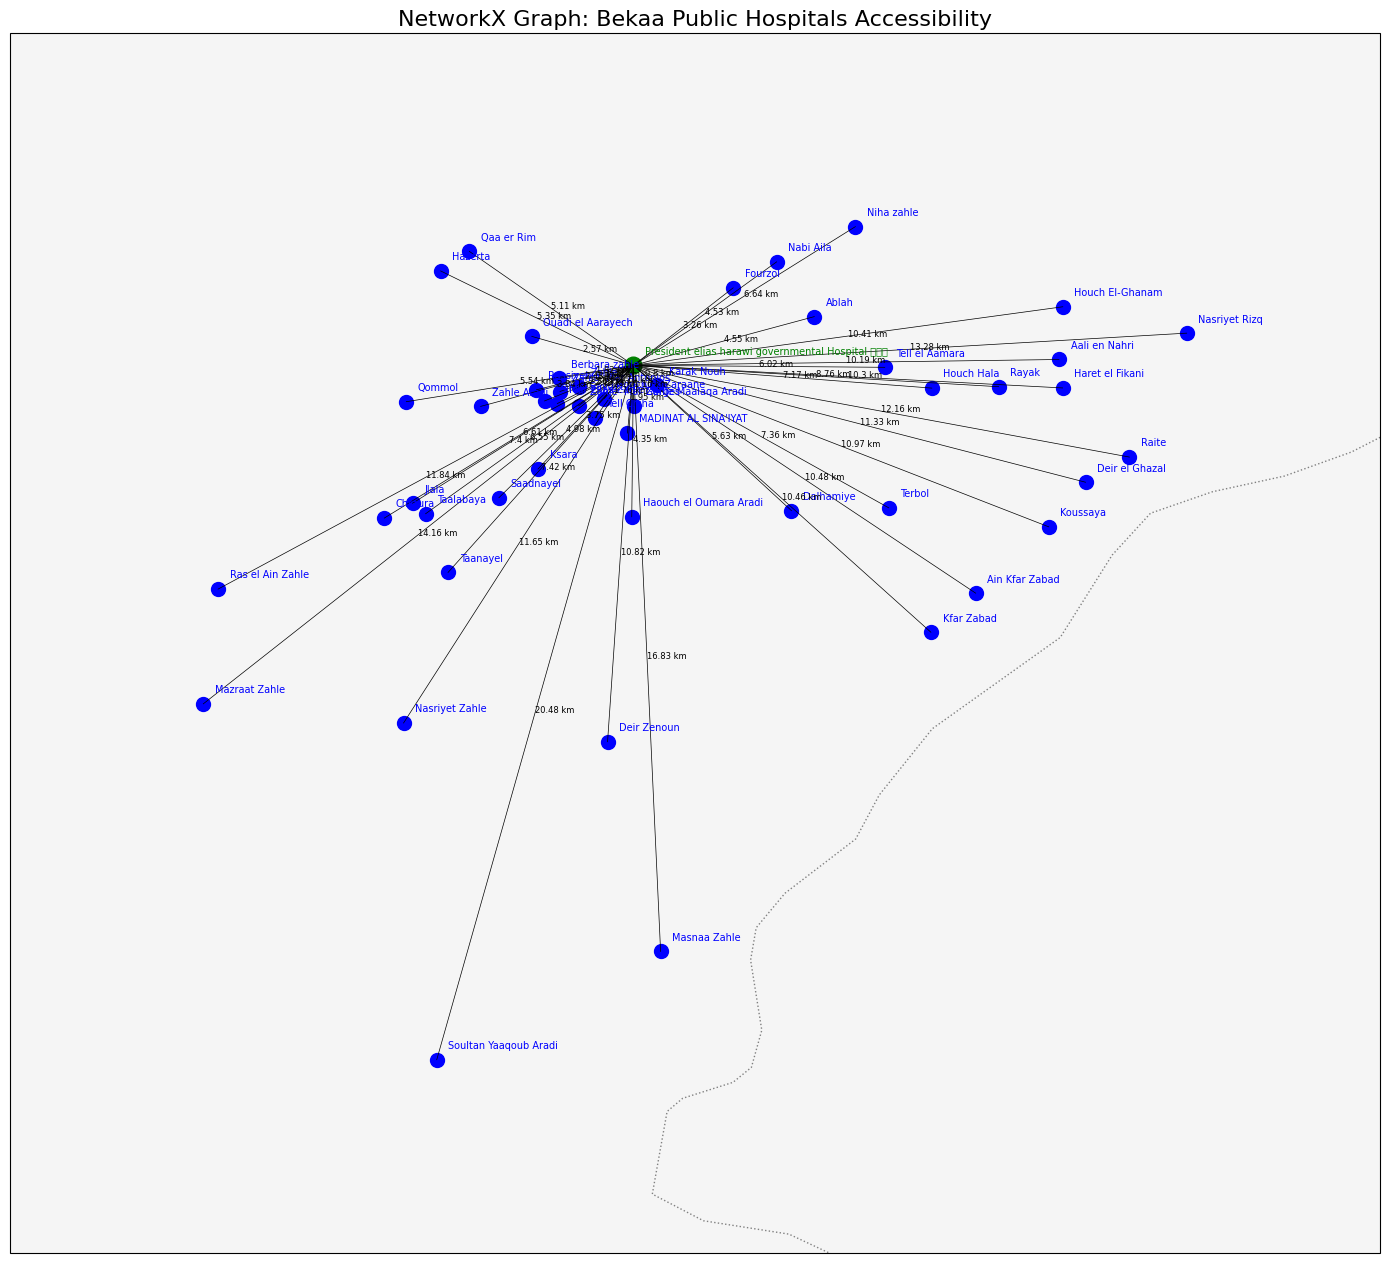

In [ ]:
import pandas as pd
import networkx as nx
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ----------------------------
# Step 1: Load CSV Data
# ----------------------------
cities_df = pd.read_csv("/content/cities in bekaa.csv")
hospitals_df = pd.read_csv("/content/public hospitals in bekaa.csv")

# Clean column names
cities_df.columns = cities_df.columns.str.strip().str.replace('\ufeff', '')
hospitals_df.columns = hospitals_df.columns.str.strip().str.replace('\ufeff', '')

# ----------------------------
# Step 2: Build the Graph
# ----------------------------
G = nx.Graph()

# Add cities as nodes
for _, row in cities_df.iterrows():
    G.add_node(row['Location Name in en'],
               type='city',
               latitude=row['latitude'],
               longitude=row['Longitude'])

# Add hospitals as nodes
for _, row in hospitals_df.iterrows():
    G.add_node(row['Name'],
               type='hospital',
               latitude=row['latitude'],
               longitude=row['longtitude'])

# Add weighted edges: distance between each city and each hospital
for _, city in cities_df.iterrows():
    city_name = city['Location Name in en']
    city_coord = (city['latitude'], city['Longitude'])

    for _, hosp in hospitals_df.iterrows():
        hospital_name = hosp['Name']
        hospital_coord = (hosp['latitude'], hosp['longtitude'])
        distance_km = round(geodesic(city_coord, hospital_coord).km, 2)

        G.add_edge(city_name, hospital_name, weight=distance_km)

# ----------------------------
# Step 3: Prepare Map
# ----------------------------
fig = plt.figure(figsize=(14, 14))
ax = plt.axes(projection=ccrs.PlateCarree())

# Get coordinate boundaries
all_lats = list(nx.get_node_attributes(G, 'latitude').values())
all_lons = list(nx.get_node_attributes(G, 'longitude').values())

min_lon = min(all_lons) - 0.05
max_lon = max(all_lons) + 0.05
min_lat = min(all_lats) - 0.05
max_lat = max(all_lats) + 0.05
ax.set_extent([min_lon, max_lon, min_lat, max_lat])

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='whitesmoke')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# ----------------------------
# Step 4: Draw Nodes and Edges
# ----------------------------
for node, attr in G.nodes(data=True):
    color = 'blue' if attr['type'] == 'city' else 'green'
    size = 10 if attr['type'] == 'city' else 12
    ax.plot(attr['longitude'], attr['latitude'], 'o', color=color, markersize=size)
    ax.text(attr['longitude'] + 0.003, attr['latitude'] + 0.003, node, fontsize=7, color=color)

# Draw edges with distance labels
for u, v, attr in G.edges(data=True):
    u_attr = G.nodes[u]
    v_attr = G.nodes[v]

    ax.plot([u_attr['longitude'], v_attr['longitude']],
            [u_attr['latitude'], v_attr['latitude']],
            color='black', linewidth=0.5)

    # Midpoint for distance label
    mid_lon = (u_attr['longitude'] + v_attr['longitude']) / 2
    mid_lat = (u_attr['latitude'] + v_attr['latitude']) / 2
    ax.text(mid_lon, mid_lat, f"{attr['weight']} km", fontsize=6, color='black')

# ----------------------------
# Finalize and Show
# ----------------------------
plt.title("NetworkX Graph: Bekaa Public Hospitals Accessibility", fontsize=16)
plt.tight_layout()
plt.show()
